--- 
Project for the course in Microeconometrics | Summer 2020, M.Sc. Economics, Bonn University | [Marc Kerstan](https://github.com/McKers)

# Replication of Thushyanthan Baskaran and Zohal Hessami (2018) <a class="tocSkip">   
---

In this notebook are my results of the replication of the core results of the following paper:  

* Baskaran, Thushyanthan, and Zohal Hessami. 2018. "Does the Election of a Female Leader Clear the Way for More Women in Politics?" American Economic Journal: Economic Policy, 10 (3): 95-121. DOI: 10.1257/pol.20170045

- The original paper and its corresponding data are  available at: https://www.aeaweb.org/articles?id=10.1257/pol.20170045. <br>

- For the purpose of comparison are all tables and figures presented in section 5 named as in the original paper


---

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import seaborn as sb
import statsmodels as sm
import statsmodels.formula.api as smf
import statsmodels.api as sm_api
import scipy.interpolate
import rpy2
import rpy2.robjects as ro

In [2]:
from rpy2.robjects.packages import importr
from rpy2.robjects import DataFrame, FloatVector
from matplotlib.pyplot import figure
from auxiliary.functions import *
from auxiliary.data_processing import *
from auxiliary.plots import *
from localreg import *
from IPython.display import Image

---

In [3]:
utils = importr("utils")
utils.chooseCRANmirror(ind=1)
utils.install_packages("rdrobust")
utils.install_packages("foreign")
utils.install_packages("rdd")
rdrobust =importr("rdrobust")
rddpack=importr("foreign")
rddpack=importr("rdd")
grdevices = importr('grDevices')

---
# Table of contents
1. [Introduction](#introduction)
2. [Experiment Setting & Voting System](#Experiment_Setting_&_Voting_System)
3. [Identification](#ID)
4. [Empirical Analysis](#Empirical_Analysis)    
5. [Replication Study](#Replication_Study) 
    1. [Data and Descriptive Summary](#Data_and_Descriptive_Summary)
    2. [Vailidity of the RD Design](#Vailidity_of_the_RD_Design)
        1. [Pretreatment Municipality Characteristics](#Pretreatment_Municipality_Characteristics)
        2. [Discontinuity in Density](#Discontinuity_in_Density)
        3. [Confoundedness with Mayor Ideology](#Confoundedness_with_Mayor_Ideology)
    3. [Main Results](#Main_Results)
        1. [Graphical Evidence](#Graphical_Evidence)
        2. [Main Result I](#Main_Result_I)
        3. [Main Result II](#Main_Result_II)
6. [Extension](#Extension) 
    1. [Data and Descriptive Summary for Main Analysis](#Data_and_Descriptive_Summary_for_Main_Analysis)
    2. [Treatment Effect Heterogeneity with Regards to Council Candidate Characteristics](#Treatment_Effect_Heterogeneity_with_Regards_to_Council_Candidate_Characteristics)
7. [Critical Assessment and Conclusion](#Critical_Assessment_and_Conclusion) 
8. [References](#Keks)


---
# 1. Introduction <a name="introduction"></a>
---

Baskaran & Hessami (2018) analyze the impact of the election of a female mayor on the subsequent electoral results of female local council candidates. The setting of this analyzes is the german federal State Hesse where both, the mayor and the local council are important administrative/political institutions on a municipality-level. The election of the local council follows an open list electoral rule, which enables the authors to measure the performance of candidates with two independent variables. The first is the election status, meaning that a female candidate has been elected to the local council or not. The second variable is the rank improvement of a candidate on their party list. Since voters can allocate their votes relatively freely across parties and candidates, individual candidates can be promoted or demoted on their party list. By relating rank improvement on the party list to the gender of a candidate the authors can assess the performance of female candidates, regardless of election status. <br>
As women generally remain underrepresented in politics the analysis by the authors gives insight on how voters react to female politicians and through which channels underrepresentation of women in politics can be counteracted. By implementing a **regression discontinuity design** for **close gender-mixed mayor elections** the authors find a significant positive effect on the performance of female candidates in council elections if a  female mayor has been elected into office in the previous election. This leads the authors to conclude that the election of a high ranking female politician reduces anti-female voter bias, in turn suggesting that an effective way to eliminate the underrepresentation of women in politics is to encourage women to compete for high ranking political office. Overall my replication supports the findings made by Baskaran & Hessami (2018).




| **Treatment**  | **Main outcomes**  | **Assignment Variable**  | **Main Covariates**  |
|---|---|---|----|
| Female Mayor   |  Rank Improvment   | Margin of Victory        | Municipality Characteristics   |
|                |  Election Status   |                          | Party of Mayor  |

The remainder of this notebook is structured as follows. Section 2 describes the experimental setting and the voting systems as presented by Baskaran and Hessami (2018). Their strategy to identify a causal effect the authors will be shown in section 3. Section 4 explains the empirical methodology used by the authors. In section 5, I conduct my replication study of the main results. Extensions to the original paper are in section 6 and section 7 concludes this notebook.

---
# 2. Experiment Setting & Voting System <a name="Experiment_Setting_&_Voting_System"></a>
---

Generally speaking, municipalities and equivalently municipality administrations in Hesse have enough (political) autonomy to affect the life of its citizens. They provide various public goods such as daycare facilities and social services, while also determining several regulations such as traffic rules or closing hours. Political decision-makers in the city council can, therefore, excel a significant influence on their citizens. <br>
The single highest-ranking official within a municipality is its mayor. The mayor is appointed for six years through the election by the citizens of that municipality. In most cases, a candidate for mayors office is a member of a party in the municipality (although it is possible to run as an independent candidate). Consequently, a small and a large field of candidates is possible. The winner of the election is determined by absolute majority rule in a maximum of two election rounds. If in the first round no candidate can reach an absolute majority of votes, a second-round will be conducted, with the two candidates, that received the most votes in the first round. The winner of that round becomes the elected mayor of that municipality. <br>
On a municipality level, the main decision-making body is the local council (that can be interpreted as a municipality-level parlament). It monitors the administration and decides upon important local policy decisions.
For all municipalities in Hesse, the election of council members takes place at a uniform date, and council members are elected for five years. The voting system follows an open-list electoral rule, which has two key properties for the analysis of Baskaran and Hessami (2018). The first one is that before the election parties set up a list of candidates for the upcoming election. On this list, every candidate is assigned a rank, ranging from one to the maximum number of council seats available (a lower number of candidates than council seats, is equally possible).<br> For an individual candidate to become a council member two factors are relevant. First, the number of list candidates that are elected is determined by the overall share of votes a party receives. Secondly, which candidate becomes a city council member is influenced by the rank of the candidate, where ranks with a lower number are advantageous as it increases the likelihood of receiving a council seat.<br>
The second relevant property is that voters can allocate their votes in various manners. Generally, every voter has as many votes as there are council seats available. The simplest way would be to make a cross for the entire party. Assuming that the list has as many candidates as there are council seats, every candidate would receive one vote. In the case that the list is shorter than the number of candidates, the first few candidates would receive an additional vote until the maximum number of votes is reached. Next, there is the possibility to strike out individual candidates on a party list, resulting again in additional votes for the candidates placed at the top of the list. However, there is also the possibility to allocate the votes on individual candidates across different parties, where three votes are the maximum a candidate can receive from one voter. This enables candidates to accumulate more votes than the candidate placed in front of him in the initial list. That implies that the candidate would move up in ranks the post-election list and has an increased chance of receiving a set. Intuitively, this rank improvement expresses the preference for a specific candidate relative to other candidates, independent of the appointment to the city council.

---
# 3. Identification <a name="ID"></a>
---

Baskaran and Hessami (2018) analyze the impact of a female mayor on the average performance of female council candidates. Ideally, one would set up a randomized experiment to quantify the effect of such treatment, where municipalities are randomly assigned to treatment and control groups. The election of a female mayor can then be interpreted as an exogenous treatment for the municipality. One can then compare the performance of female candidates in the subsequent council election of the treatment group and the control group to determine the average treatment effect. Since treatment is assigned randomly we can neglect underlying characteristics in municipalities which might affect the magnitude of the treatment effect on female council candidate performance.<br> Denoting the average performance of a female council candidate as $Y$ and the corresponding treatment indicator as $D$, the average treatment effect is the difference in expected outcomes, conditional on treatment status:
<br>
\begin{equation} 
E[Y\mid D=1]-E[Y\mid D=0]=\tau_{r}
\end{equation}
<br>
where D is 1 if a female mayor has been "assigned" in the last election and 0 for the other case. $\tau$ is then our unbiased average treatment effect. <br>
However, the expression above does not result in an unbiased estimator of the treatment effect in the setting by Baskaran and Hessami (2018). This is because in this environment treatment assignment is not random, but determined by the outcome of an election. Due to the complex nature of voting decisions in political elections, it is reasonable to assume that there are many possible confounding factors when it comes to the choice if a municipality selects into treatment by electing a female mayor (and vice versa). An intuitive example in this context would be a possible distaste for women in politics. If such a confounding factor is present, this would not only affect the performance of a female council candidate but also the assignment into treatment and control group, as it is unlikely for a municipality with such a distaste to select into treatment. An unbiased estimation based on the equation above is then not possible because treated and untreated groups differ significantly in their observable and unobservable characteristics. This problem can be visualized by causal graph 1.  

Causal Graph 1

![ERROR:Here should be causal graph 1](files/causalgraph1.PNG)

The goal is to identify the effect of D on the outcome variable $Y$. However,  there are two challenges in this setting. The first one is the relationship of the assignment variable $X$ with the variables $W$ and $U$. As one can see, the status of the treatment indicator D is determined by the variable $X$. In the setting of Baskaran and Hessami (2018) $X$ is the margin of victory of a female candidate for the office of mayor in a mixed-gender election. If a female mayor candidate is victorious, the assignment variable would take on a positive value and induce the treatment indicator $D$ to be one. In case of a defeat of the female mayor candidate, $X$ is negative, no treatment takes place and the respective municipality is in the control group. Consequently, the factors determining the margin of victory also affect the assignment of treatment. These factors are summarized as the variables $W$ and $U$, which represent all observable and unobservable factors that influence the margin of victory of a female mayor. Since these variables influence treatment assignment, the split of  the  test population into control and treatmen group is non-random. Usually, this issue is solved by conditioning on these variables. But this is only partially possible here since it is not possible to condition on unobservable characteristics.   <br>
The second problem is the confounding nature of the variable $X$, because the margin of victory might not only affect the performance of female candidates through the assignment of treatment. $X$ itself may exert an effect on the performance of female council candidates. An example would be a landslide victory of a male mayor candidate against an unqualified female mayor candidate. In this case, the municipality would select into the control group, but due to the weak performance of the female candidate, voters might relate this performance to the gender of council candidates in a subsequent council election, resulting in a weak electoral result of female candidates. Again,  one would try to solve this problem by conditioning on the $X$, and observe the treatment effect for different subgroups of $X$. Unfortunately, this is not possible in our setting due to the role of $X$ as assignment variable of treatment. This can be illstrated by assuming (for simplicity) that $X$ can only take on two realizations that satisfy: $x_1<0<x_2$. In this case, we cannot observe the impact of treatment in the population where $X=x_1$, since being in $x_1$ and simultaneously being assigned to treatment is mutually exclusive. <br> Facing these problems one cannot identify a causal relationship based on the back-door-criterion as it is not possible to close all backdoor paths.
  
To overcome these issues and identify a causal effect of $D$ on $Y$, Baskaran & Hessami (2018) apply a regression discontinuity design. The underlying idea of this approach is that under a certain condition,  treatment assignment to the test population is locally randomized around a predefined cutoff value. This requires that treatment takes place just above the cutoff, whereas under it no treatment takes place. Under this quasi-randomized experimental setting causal interpretation of a treatment effect is possible, since agents who are just below the threshold of receiving treatment represent reasonable counterfactuals of those that receive treatment. <br> In Baskaran & Hessami (2008) the cutoff value for treatment is reached ones a female mayor candidate receives more than $50\%$ of votes, meaning that $X$ is positive. Following the logic of a regression discontinuity design, we can now treat the assignment of treatment  as locally randomized close to this cutoff.<br>
However, for an regression discontinuity design to be valid in identifying a causal effect, the test population (municipality) has to be unable to precisely manipulate the assignment variable around the cutoff, meaning they may only exert imprecise control over the assignment variable close to the cutoff. This can intuitively be explained by thinking of a mayor election between two candidates, where all votes but one are counted and amount to a draw. The last voter then decides to make his voting decision by a coin flip. While voters were generally able to manipulate the assignment variable to be close to the cutoff, the voters were only able to manipulate it imperfectly as the final treatment assignment was determined entirely by chance. <br>
A more formal definition is given by:

<h5 align="center" >"We say individuals have imprecise control over $X$ when conditional on $W$ $=$ $w$ and $U$ $=$ $u$, the density of $V$ (and hence $X$) is continuous." (Lee and Lemieux,2010,p.295)</h5>  

Mathematically, this takes on the following form
\begin{align*}
Pr[W = w, U = u \mid X = x]. 
\end{align*}
Applying Bayes' theorem and setting $x=c$, with c being the cutoff of treatment assignment, it follows that

\begin{align*}
& \Pr[W = w, U = u \mid X = c] 
\quad = \quad f(c \mid W = w, U = u) \quad\frac{\Pr[W = w, U = u]}{f(c)}.
\end{align*}

The expression implies that $W$ and $U$ follow the same conditional distribution at the cutoff, independant of treatment assignment. Accordingly treatment assignment is "as good as random" (Lee and Lemieux,2010,p.295), as all differences in realizations of $W$ and $U$ are determined by chance. The implication is that the treatment effect takes on  the following form
\begin{align*}
  &\lim_{ε↓0}E[Y|X = c + ε]-\lim_{ε↑0}E[Y |X = c + ε]\quad=\quad τ.
\end{align*}


For the setting in Baskaran and Hessami (2018), if the criterion of imprecise control near the cutoff is fulfilled causal inference is possible as presented by causal graph 2.


Causal Graph 2

![ERROR:Here should be causal graph 1](files/causalgraph2.PNG)

This graph follows the same logic as causal graph 1, with the difference that we restrict our view to values of $X$ close around the cutoff of treatment assignment. First, notice that the assignment variable is no longer a confounding factor since all effects of $X$ on  $Y$ are only due to the change in treatment assignment. Similarly, W and U now follow the same distribution on either side of the cutoff. Consequently, their realization is randomly determined for a given municipality and not correlated with $X$. <br>
In the setting of Baskaran and Hessami (2018) this means that if we restrict our look to mix gender elections, where the female or male candidate for mayors office, won the election by a margin "small enough", all observable and unobservables that could influence treatment assignment are now (locally) random. Accordingly,  this implies the arbitrary designation of treatment. Consequently, a causal interpretation of the victory of a female candidate is possible for close gender-mixed elections. 

---
# 4. Empirical Analysis <a name="Empirical_Analysis"></a>
---

In order to determine the treatment effect, the authors consider $two$ $different$ $dependant$ $variables$, the $rank$ $improvement$ of a female candidate within a party voting list and secondly the $gender$ $of$ $an$ $elected$ $council$ $candidate$. The authors formalize the  former  as follows:

<br>
\begin{equation} 
rank\: improvement = \left(\frac{initial\:rank - final\:rank}{council\:size}\right) \times   100
\end{equation}

<br>
Following this design improvement in ranks, meaning a candidate receives more preferential votes than the candidate in front of him on the initial list, has a positive sign, and degradation is labeled with a minus sign. The change in ranks is then normalized by council size and multiplied by 100 to ensure comparability between different municipalities since the actual number of council seats differ considerably. <br>
The $second$ $dependant$ $variable$ is a dummy variable that takes on the value one if an elected council candidate is female and zero otherwise. Consequently, the analysis of these dependant variables differs in their sample structure, since the analysis on rank improvement only includes female candidates which may or may not have been elected. However, the second analysis includes all candidates that won a council seat, independent of gender.<br>
The effect of a female mayor for both dependent variables is estimated by linear and quadratic local regression using identical functional designs for both outcome variables. Formally, the regression model is 



\begin{equation} 
dependant\:variable_{k,i,t}\:=\:\alpha\:+\:\beta female\: mayor_{i,t} \:+\:f(vote\:margin)_{i,t}\:+\:female\:mayor_{i,t}\:\times\:g(vote\:margin)_{i,t}\: + \:\varepsilon_{k,i,t}.
\end{equation}


The indices $k$,$i$, and $t$ refer to the individual council candidate, the municipality, and the year of the council election respectively. Variable $female$ $mayor$ is a dummy that takes on the value one if a female mayor was elected in the last mayoral election. The functions  $f(\cdot)$ and $g(\cdot)$ are linear (or quadratic) functions of $vote$ $margin$, the percentage margin of victory of the female mayor candidate in the preceding mayor election, our assignment variable in the regression discontinuity design. Since we want to explore the impact of a female mayor, the margin of victory is positive above the cutoff of 0% and negative otherwise, implying the defeat of the female candidate. <br>
In addition to the functional form of the regression, the chosen bandwidth, the amount of data included in the estimation relative to the cutoff point, is critical. In order to achieve an unbiased treatment we rely on the criteria of local randomization as argued above. This would encourage to restrict our analysis as close as possible to the cutoff. This however implies that less  data is available to estimate the treatment, effect resulting in higher variance in the estimation of the treatment effect. To overcome this problem, Baskaran & Hessami (2018) estimate equation (2) for five different bandwidths for each of the outcome variables. The bandwidths chosen are the ones proposed by Calonico, Cattaneo, and Titiunik (2014), half of this bandwidth, and double of it. Estimates according to the bandwidth proposed by Imbens & Kalyanaraman (2012) are also included. Additionally, one model estimates the effect by including quadratic terms of $vote$ $margin$ and its interaction with $female$ $mayor$. The underlying process to determine the bandwidth for this specification is again chosen according to Calonico, Cattaneo, and Titiunik (2014). For all calculations, the authors use heteroscedasticity-robust and municipality-level clustered standard errors for hypothesis testing.

---
# 5. Replication Study <a name="Replication_Study"></a>
---

---
## 5.1 Data and Descriptive Summary <a name="Data_and_Descriptive_Summary"></a>
---

To assess the data used by Baskaran and Hessami (2018) a distinction between the data for mayoral elections and the data for council elections has to be made.
The data set for mayoral elections stems directly from the Statistical Office of Hesse and contains data on all mayoral elections taking place between 1993  -2015, including dates, number of votes, party affiliation,  gender and names of the  respective candidate.<br>
The data for council elections is less consistent. For council elections in the year 2016 administrative data is provided by the Statistical Office of Hesse (consisting of the initial list rank, their final position as well as gender and name). This type of data is not available for previous elections, which required the authors to hand collect the data through various means of communication with municipality administration officials and official municipality websites.<br>

## Figure 1. Sample Coverage

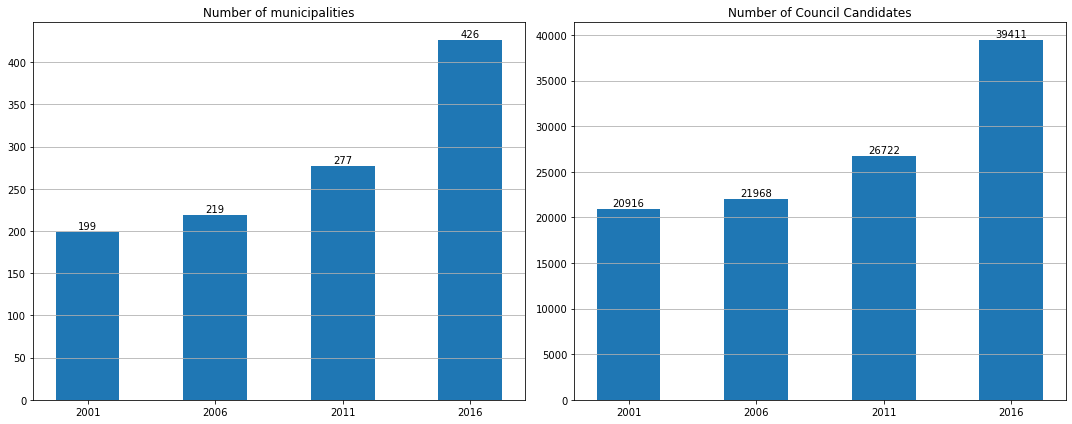

In [5]:
data=pd.read_stata("Data/main_dataset.dta")
fig1_a=data_fig1_a(data)
fig1_b=data_fig1_b(data)
plt1_1=(fig1_a[0])
plt2_1=(fig1_b[0])
figure1_plot(plt1_1,plt2_1)

Figure 1 depicts the overall sample coverage of local council elections analyzed by the authors. The bar chart on the left-hand side shows the total number of single municipalities in the sample, clustered by years of council elections. The right-hand side shows the same statistic but on an individual candidate level. As it is visible the data coverage declines considerably when moving further into the past. This is attributed to the fact that the authors had to collect the data for those elections manually since no central source was available.

## Table 1 - Summary Statistics For Candidate Characteristics

In [5]:
Table1_a=table1(data, dictionary_table1(), female=False)
Table1_b=table1(data, dictionary_table1(), female=True)
display_side_by_side(Table1_a,Table1_b)

,count,mean,std,min,max
Rank improvement (normalized),109017.0,0.066676,13.253290,-89.189186,97.297295
Initial list rank (normalized),109017.0,40.101704,26.774668,0.000000,100.000000
Age,54676.0,51.580711,13.780560,18.000000,102.000000
High school,48729.0,0.650578,0.476792,0.000000,1.000000
University,48729.0,0.281598,0.449783,0.000000,1.000000
Phd,48729.0,0.067824,0.251446,0.000000,1.000000
Architect,49399.0,0.008603,0.092356,0.000000,1.000000
Businesswoman/-man,49399.0,0.075892,0.264828,0.000000,1.000000
Engineer,49399.0,0.055305,0.228576,0.000000,1.000000
Lawyer,49399.0,0.031377,0.174337,0.000000,1.000000


Table 1 presents summary statistics on (normalized) rank improvement, initial list rank, age, and occupational characteristics of candidates. The left table contains data on all council candidates while the right one is restricted to female candidates. The fact that we observe a (small) positive average rank improvement for all candidates is attributed to the normalization as outlined in section 4. Additionally, it is noteworthy that on average women are demoted by voters. To determine the signficance of this finding 

## Table A.2: Differences In Initial List Placement And Rank Improvement, Female vs. Male Candidates 

In [6]:
tt_rank=t_test_prepare_rank(data)
ttest(tt_rank,"Rank")

,Treatment,Control,Diff,Std. Error,Observations
Rank,,,,,
Rank improvement (normalized),-0.459000,0.252,-0.711***,0.091,109017.0
Initial list rank (normalized),38.816002,40.556,-1.74***,0.185,109017.0


The table above presents the results of t-tests performed to test whether there are significant differences in the rank improvement and initial rank between female and male candidates. Following the results, female candidates perform worse in rank improvement and are initially placed better than male candidates. However, these results are far from conclusive, since the underlying mechanism (list placement of candidates by parties) or potential omitted variables are neglected.

---
## 5.2 Vailidity of the RD Design <a name="Vailidity_of_the_RD_Design"></a>
---

As described in section 4,  the validity of a regression discontinuity design depends on the assumption that agenst habe only imprecise control over the assignment variable at the cutoff. Baskaran and Hessami (2018) perform therefore several different test in order to show the validity of their approach.

### 5.2.1 Pretreatment Municipality Characteristics <a name="Pretreatment_Municipality_Characteristics"></a>
---

One possible pitfall for the validity of the outlined methodology could be if municipalities that elect a female mayors differ structurally from those that do not. To test if this is the case the authors perform t-tests on several observable characteristics of municipalities. For these tests, the sample as outlined above is reduced to data of council elections, where the previous mayor election was between candidates of a different gender. Since this subset of the data will be used frequently from now on, this sample will be referred to as **rdd-sample**.

## Table A.4: Validity Test I: Differences In Municipality Characteristics With Female And Male Mayors

In [7]:
mayor_df=pd.read_stata("Data/mayor_election_data.dta")
municipality_df=pd.read_stata("Data/municipality_characteristics_data.dta")
df_ttest_ch=mayor_df.merge(right= municipality_df, how='inner', on=['gkz','jahr']).loc[(mayor_df["rdd_sample"] == 1)]
df_ttest_ch_10=subset_by_margin(df_ttest_ch,10)
test_ch_all=t_test_prepare_cha(df_ttest_ch)
ttest(test_ch_all,"Municipality Characteristics")

,Treatment,Control,Diff,Std. Error,Observations
Municipality Characteristics,,,,,
Log(population),9.384,9.211,0.173,0.121,268.0
Log(land area),3.632,3.611,0.021,0.100,268.0
Log(debt p.c.),-0.364,-0.513,0.149,0.118,268.0
Log(tax revenues p.c.),-0.392,-0.430,0.038,0.053,268.0
Log(local gov. employment p.c.),-5.129,-5.158,0.029,0.051,268.0
"Log(female share, local gov. employment)",-1.076,-1.156,0.08*,0.046,265.0
Log(total employment p.c.),-1.627,-1.540,-0.087,0.076,268.0
"Log(female share, total employment)",-0.833,-0.850,0.017,0.029,268.0
Log(manufacturing / total employment),-1.137,-1.060,-0.077,0.068,268.0


The t-tests report statistically significant differences in the shares of female employment in the local administration and the manufacturing industry at a significance level of 10% and 5%. However, this difference vanishes when looking at differences of municipalities closer to the cutoff as the table below shows. 

In [8]:
test_ch_10=t_test_prepare_cha(df_ttest_ch_10)
ttest(test_ch_10,"Municipality Characteristics")

,Treatment,Control,Diff,Std. Error,Observations
Municipality Characteristics,,,,,
Log(population),9.821,9.219,0.602*,0.300,55.0
Log(land area),3.972,3.771,0.201,0.193,55.0
Log(debt p.c.),-0.264,-0.253,-0.011,0.243,55.0
Log(tax revenues p.c.),-0.306,-0.327,0.021,0.115,55.0
Log(local gov. employment p.c.),-4.929,-5.080,0.151,0.145,55.0
"Log(female share, local gov. employment)",-1.044,-1.146,0.102,0.098,55.0
Log(total employment p.c.),-1.332,-1.490,0.158,0.152,55.0
"Log(female share, total employment)",-0.887,-0.885,-0.002,0.058,55.0
Log(manufacturing / total employment),-1.042,-0.981,-0.061,0.126,55.0


Restricting the rdd-sample to a 10 percent margin of victory on both sides of the cutoff reveals no statistically significant differences in the local employment structure. However, at a significance level of 10%, an increased frequency of female mayor in cities with higher populations can be observed. The effect is barely significant and the authors attribute it to the highly skewed distribution of city sizes.

## Table A.5: Validity Test I: Discontinutiy In Predicted Rank Improvement Based on Municipality Characteristics

Baskaran and Hessami (2018) further analyze if the above-observed differences in municipalities result in a discontinuity of the margin of victory at the cutoff. To test this the authors restrict the rdd-sample to female candidates and regress their performance on the observed municipality characteristics. They use the resulting parameters to construct the predicted average rank improvement of a female candidate. These predicted values are then used as the dependant variable in their model shown in section 4.

In [12]:
data_rdd_f=get_rdd_data(data,female=True)
df_TableA5=prepare_TableA5(data_rdd_f)
df_A5_r = DataFrame({"margin_1": FloatVector(df_TableA5["margin_1"]), "y_hat": FloatVector(df_TableA5["y_hat"])})
CCT_bw_A5=rdrobust.rdbwselect_2014(df_A5_r.rx2('y_hat'), df_A5_r.rx2('margin_1'), c = 0, p = 1, q = 0, deriv = 0,kernel = "tri", bwselect = "CCT")[2][0]
IK_bw_A5=rdrobust.rdbwselect_2014(df_A5_r.rx2('y_hat'), df_A5_r.rx2('margin_1'), c = 0, p = 1, q = 0, deriv = 0,kernel = "tri", bwselect = "IK")[2][0]
CCT_quad_bw_A5=rdrobust.rdbwselect_2014(df_A5_r.rx2('y_hat'), df_A5_r.rx2('margin_1'), c = 0, p = 2, q = 0, deriv = 0,kernel = "tri", bwselect = "CCT")[2][0]
print("The optimal bandwith according to Calonico, Cattaneo & Titiunik (2014) is: {:5.3f}".format(CCT_bw_A5))
print("The optimal bandwith according to Imbens & Kalyanaraman (2011) is: {:5.3f}".format(IK_bw_A5))
print("The optimal bandwith according to Calonico, Cattaneo & Titiunik (2014) using a quadratic functional form is: {:5.3f}".format(CCT_quad_bw_A5))

The optimal bandwith according to Calonico, Cattaneo & Titiunik (2014) is: 18.805
The optimal bandwith according to Imbens & Kalyanaraman (2011) is: 35.682
The optimal bandwith according to Calonico, Cattaneo & Titiunik (2014) using a quadratic functional form is: 24.763


In [10]:
result1=[df_TableA5,"linear",CCT_bw_A5,"y_hat","CCT"]
result2=[df_TableA5,"linear",CCT_bw_A5/2,"y_hat","CCT/2"]
result3=[df_TableA5,"linear",CCT_bw_A5*2,"y_hat","CCT*2"]
result4=[df_TableA5,"linear",IK_bw_A5,"y_hat","IK"]
result5=[df_TableA5,"quadratic",CCT_quad_bw_A5,"y_hat","CCT"]
reg_tab(result1,result2,result3,result4,result5)

,Female Mayor,Std.err,Bandwidth type,Bandwidth size,Polynominal,Observations,Elections,Municipalities,Mean,Std.err (Mean)
Model,,,,,,,,,,
(1),0.422,0.801,CCT,18.8,Linear,71.0,71.0,52.0,-0.45,1.172
(2),0.408,1.142,CCT/2,9.4,Linear,44.0,44.0,35.0,-0.52,1.188
(3),0.855*,0.508,CCT*2,37.61,Linear,143.0,143.0,96.0,-0.54,1.160
(4),0.847,0.525,IK,35.68,Linear,136.0,136.0,94.0,-0.53,1.162
(5),0.114,1.032,CCT,24.76,Quadratic,101.0,101.0,74.0,-0.50,1.164


Testing the model for the variations as outlined in section 4, the regression shows a significant effect of a female mayor for model 3. However, the effect is barely significant and vanishes as we move closer to the cutoff. The corresponding regression discontinuity plot of the predicted average rank improvement relative to the assignment variable can is presented below.

## Figure A.1: Validity Test I: Predicted (Normalized) Rank Improvement Based Municipality Characteristics

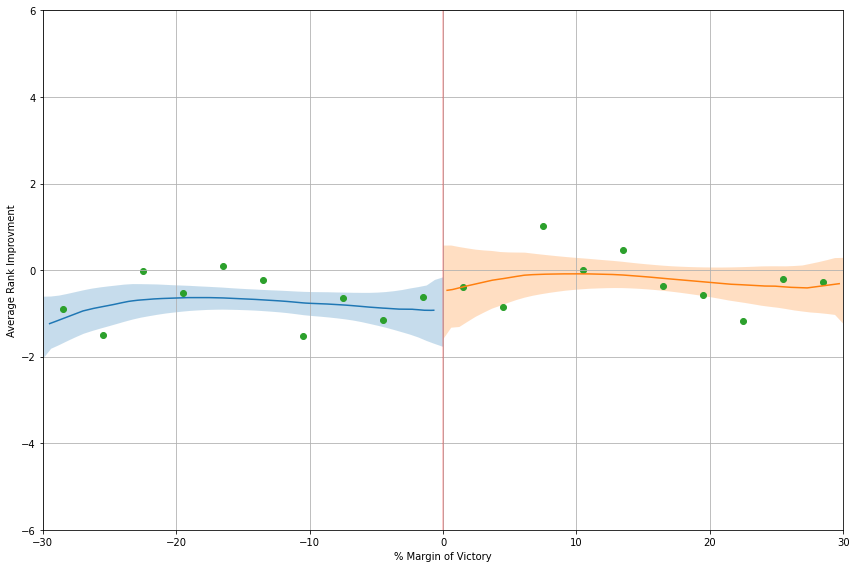

In [11]:
figure_A1=subset_by_margin(df_TableA5,30)
rdd_plot(figure_A1,3,CCT_bw_A5,100,1,"y_hat")

---
<span style="color:red">**NOTE**:</span> 
  The confidence intervals above are the result of 100 iterations of resampling the data by bootstrapping. Increasing the number of iterations does not yield different results and only increases the runtime of this notebook.
---

The dots are the local averages of the predicted rank improvement in bins of a 3 percent margin and the lines are the result of a local linear smooth of the data on each side of the cutoff. The colored areas are the 95 percent bootstrapped confidence intervals of the smooth. There is no indication of a discontinuity conditional on municipality characteristics observable.

---
### 5.2.2 Discontinuity in Density <a name="Discontinuity_in_Density"></a>
---

## Figure A.2: Validity test II: McCrary Density Plot

The authors further test for a general discontinuity in running variable at the cutoff by performing the density test proposed by McCrary (2008). The corresponding McCrary plot is depicted below and shows no significant discontinuity.

In [12]:
mayor_df=pd.read_stata("Data/mayor_election_data.dta")
mayor_df_rdd=mayor_df[mayor_df["rdd_sample"]==1].sort_values(by=['margin_1'])
mayor_df_r = DataFrame({"margin_1": FloatVector(mayor_df_rdd["margin_1"])})

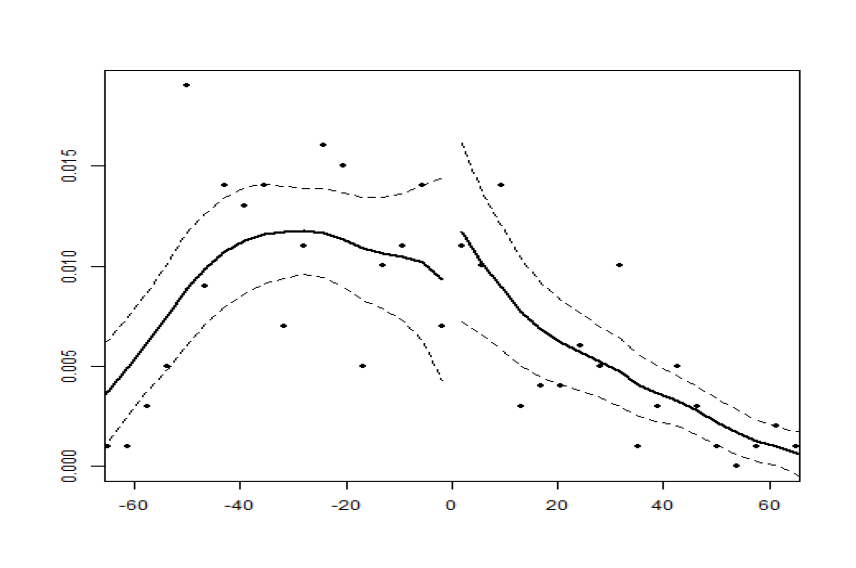

In [13]:
grdevices.png(file="MCC_Test1.png", width=512, height=512)
p = rddpack.DCdensity(mayor_df_r.rx2("margin_1"),cutpoint=0,plot=True)     
grdevices.dev_off()
img=mpimg.imread('MCC_Test1.png')
fig, ax0 = plt.subplots(1, 1, figsize=(12, 8), tight_layout=True)
ax0.imshow(img,aspect='auto')
plt.axis('off') 
plt.show()

---
### 5.2.3 Confoundedness with Mayor Ideology <a name="Confoundedness_with_Mayor_Ideology"></a>
---

## Table A.7: Validity Test III: Differences In Ideology Of Female And Male Mayors

Another possible pitfall for a causal interpretation of the regression discontinuity design in Baskaran and Hessami (2018) could be the ideological difference in elected male and female mayor. If such a systematic difference is present,  voters might prefer female council members if they think that they can work more effectively with the mayor of a given ideology. Using party affiliation as a proxy for ideological differences the authors test if female and male candidates differ systemically in their party membership.  The results of the corresponding t-tests are presented below, where the first table reports outcomes for the entire rdd-sample, and the second table shows the results for elections where the winner was determined within a 10 percent vote margin. None of the differences are statistically significant, suggesting no difference in ideology between elected female and male mayors.

In [14]:
ttest_pa_all=t_test_prepare_party(mayor_df_rdd)
mayor_df_rdd_test_10=subset_by_margin(mayor_df_rdd,10)
ttest_pa_10=t_test_prepare_party(mayor_df_rdd_test_10)
ttest(ttest_pa_all,"Party")

,Treatment,Control,Diff,Std. Error,Observations
Party,,,,,
CDU,0.31,0.315,-0.005,0.061,268.0
SPD,0.44,0.386,0.054,0.065,268.0
Other,0.25,0.299,-0.049,0.059,268.0


In [15]:
ttest(ttest_pa_10,"Party")

,Treatment,Control,Diff,Std. Error,Observations
Party,,,,,
CDU,0.448,0.308,0.14,0.130,55.0
SPD,0.276,0.308,-0.032,0.123,55.0
Other,0.276,0.385,-0.109,0.126,55.0


---
##  5.3 Main Results <a name="Main_Results"></a>
---

### 5.3.1 Graphical Evidence <a name="Graphical_Evidence"></a>
---

## Figure 2. Rank Improvement of Female Candidates

In [16]:
data_rdd=get_rdd_data(data,female=False)
df_r = DataFrame({"margin_1": FloatVector(data_rdd_f["margin_1"]), "gewinn_norm": FloatVector(data_rdd_f["gewinn_norm"])})
CCT_bw_I=rdrobust.rdbwselect_2014(df_r.rx2('gewinn_norm'), df_r.rx2('margin_1'), c = 0, p = 1, q = 0, deriv = 0,kernel = "tri", bwselect = "CCT")[2][0]
print("The optimal bandwith according to Calonico, Cattaneo & Titiunik (2014) is: {:5.3f}".format(CCT_bw_I))

The optimal bandwith according to Calonico, Cattaneo & Titiunik (2014) is: 20.100


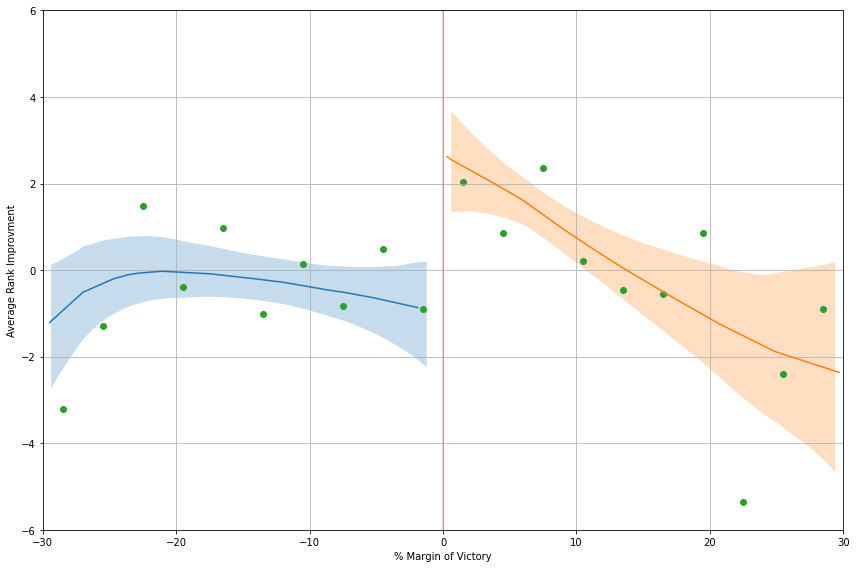

In [17]:
data_fig2=subset_by_margin(data_rdd_f,30)
rdd_plot(data_fig2,3,CCT_bw_I,100,100,"gewinn_norm")

Figure 2 shows the regression discontinuity plot for the observed rank improvement of female candidates in the rdd-sample. The dots are again the local averages of rank improvement for bins of 3 percent, the lines are the results from local linear smooths on both sides, plotted with their respective confidence intervals. Since potential confounding factors have been ruled out the observed and significant discontinuity is attributed by Baskaran & Hessami  (2018) to the treatment effect of a female mayor. At the threshold an average rank improvement of 3.7. ranks (per 100 seats) takes place if a female mayor has been recently elected into the office.

---
<span style="color:red">**NOTE**:</span> 
  The confidence intervals above are the result of 100 iterations of resampling the data by bootstrapping. Increasing the number of iterations does not yield different results and only increases the runtime of this notebook.
---

### 5.3.2 Main Result I - Rank improvement of female Council Candiates <a name="Main_Result_I"></a>
---

## Table 2 - Baseline Results: Rank Improvment fo Female Candidates

In [21]:
CCT_bw_I=rdrobust.rdbwselect_2014(df_r.rx2('gewinn_norm'), df_r.rx2('margin_1'), c = 0, p = 1, q = 0, deriv = 0,kernel = "tri", bwselect = "CCT")[2][0]
IK_bw_I=rdrobust.rdbwselect_2014(df_r.rx2('gewinn_norm'), df_r.rx2('margin_1'), c = 0, p = 1, q = 0, deriv = 0,kernel = "tri", bwselect = "IK")[2][0]
CCT_quad_bw_I=rdrobust.rdbwselect_2014(df_r.rx2('gewinn_norm'), df_r.rx2('margin_1'), c = 0, p = 2, q = 0, deriv = 0,kernel = "tri", bwselect = "CCT")[2][0]
print("The optimal bandwith according to Calonico, Cattaneo & Titiunik (2014) is: {:5.3f}".format(CCT_bw_I))
print("The optimal bandwith according to Imbens & Kalyanaraman (2011) is: {:5.3f}".format(IK_bw_I))
print("The optimal bandwith according to Calonico, Cattaneo & Titiunik (2014) using a quadratic functional form is: {:5.3f}".format(CCT_quad_bw_I))

The optimal bandwith according to Calonico, Cattaneo & Titiunik (2014) is: 20.100
The optimal bandwith according to Imbens & Kalyanaraman (2011) is: 35.587
The optimal bandwith according to Calonico, Cattaneo & Titiunik (2014) using a quadratic functional form is: 19.932


In [22]:
result1=[data_rdd_f,"linear",CCT_bw_I,"gewinn_norm","CCT"]
result2=[data_rdd_f,"linear",CCT_bw_I/2,"gewinn_norm","CCT/2"]
result3=[data_rdd_f,"linear",CCT_bw_I*2,"gewinn_norm","CCT*2"]
result4=[data_rdd_f,"linear",IK_bw_I,"gewinn_norm","IK"]
result5=[data_rdd_f,"quadratic",CCT_quad_bw_I,"gewinn_norm","CCT"]

In [23]:
reg_tab(result1,result2,result3,result4,result5)

,Female Mayor,Std.err,Bandwidth type,Bandwidth size,Polynominal,Observations,Elections,Municipalities,Mean,Std.err (Mean)
Model,,,,,,,,,,
(1),3.712***,0.980,CCT,20.1,Linear,2878.0,77.0,56.0,0.41,10.947
(2),3.322**,1.491,CCT/2,10.05,Linear,1784.0,46.0,37.0,0.73,10.750
(3),2.836***,0.548,CCT*2,40.2,Linear,5232.0,155.0,102.0,0.27,11.327
(4),3.124***,0.613,IK,35.59,Linear,4803.0,139.0,94.0,0.21,11.364
(5),3.293**,1.545,CCT,19.93,Quadratic,2842.0,76.0,55.0,0.41,10.996


Table 2 reports the results of the regression outlined in section 4, with rank improvements of female candidates as the dependant variable. For the linear models that use the bandwidths by Imbens & Kalyanaraman (2011) and Calonico, Cattaneo & Titiunik (2014) (and the bandwidth multiplied by two), the average rank improvement ranges from 2.8 to  3.7, while being significant at a level of 1 percent. The remaining two models report an average rank improvement of roughly 3.2 ranks while being significant at the 5 percent level.  

### 5.3.3 Main Result II - Share of Women Among Candidates Elected to the Council <a name="Main_Result_II"></a>
---

## Table 3 - Baseline Results II: Share of Women Among Candidates Elected to the Council

In [24]:
data_rdd_e=data_rdd[data_rdd["elected"]==1]
df_r_mix = DataFrame({"margin_1": FloatVector(data_rdd_e["margin_1"]), "female": FloatVector(data_rdd_e["female"])})
CCT_bw_II=rdrobust.rdbwselect_2014(df_r_mix.rx2('female'), df_r_mix.rx2('margin_1'), c = 0, p = 1, q = 0, deriv = 0,kernel = "tri", bwselect = "CCT")[2][0]
IK_bw_II=rdrobust.rdbwselect_2014(df_r_mix.rx2('female'), df_r_mix.rx2('margin_1'), c = 0, p = 1, q = 0, deriv = 0,kernel = "tri", bwselect = "IK")[2][0]
CCT_quad_bw_II=rdrobust.rdbwselect_2014(df_r_mix.rx2('female'), df_r_mix.rx2('margin_1'), c = 0, p = 2, q = 0, deriv = 0,kernel = "tri", bwselect = "CCT")[2][0]
print("The optimal bandwith according to Calonico, Cattaneo & Titiunik (2014) is: {:5.3f}".format(CCT_bw_II))
print("The optimal bandwith according to Imbens & Kalyanaraman (2011) is: {:5.3f}".format(IK_bw_II))
print("The optimal bandwith according to Calonico, Cattaneo & Titiunik (2014) using a quadratic functional form is: {:5.3f}".format(CCT_quad_bw_II))

The optimal bandwith according to Calonico, Cattaneo & Titiunik (2014) is: 23.900
The optimal bandwith according to Imbens & Kalyanaraman (2011) is: 21.159
The optimal bandwith according to Calonico, Cattaneo & Titiunik (2014) using a quadratic functional form is: 25.496


In [25]:
data_rdd=get_rdd_data(data,female=False)
data_rdd_e=data_rdd.loc[(data_rdd["elected"] == 1)]

result2_1=[data_rdd_e,"linear",CCT_bw_II,"female","CCT"]
result2_2=[data_rdd_e,"linear",CCT_bw_II/2,"female","CCT/2"]
result2_3=[data_rdd_e,"linear",CCT_bw_II*2,"female","CCT*2"]
result2_4=[data_rdd_e,"linear",IK_bw_II,"female","IK"]
result2_5=[data_rdd_e,"quadratic",CCT_quad_bw_II,"female","CCT"]

reg_tab(result2_1,result2_2,result2_3,result2_4,result2_5)

,Female Mayor,Std.err,Bandwidth type,Bandwidth size,Polynominal,Observations,Elections,Municipalities,Mean,Std.err (Mean)
Model,,,,,,,,,,
(1),0.041,0.042,CCT,23.9,Linear,3463.0,96.0,72.0,0.27,0.446
(2),0.045,0.043,CCT/2,11.95,Linear,2033.0,55.0,44.0,0.27,0.446
(3),0.038,0.035,CCT*2,47.8,Linear,6135.0,178.0,116.0,0.26,0.441
(4),0.042,0.043,IK,21.16,Linear,3056.0,85.0,63.0,0.27,0.446
(5),0.05,0.046,CCT,25.5,Quadratic,3796.0,107.0,77.0,0.27,0.445


Table 3 reports the results of the specified regression with a dummy variable as the dependent variable that takes on the value 1 if an elected council candidate is female. None of the different specifications report a significant effect of a female mayor.  However, this is likely due to the marginal effect of rank improvement,  as it only enables female candidates with a sufficient initial rank to get elected.

---
#  6. Extension <a name="Extension"></a>
---

##  6.1 Data and Descriptive Summary for Main Analysis <a name="Data_and_Descriptive_Summary_for_Main_Analysis"></a>
---

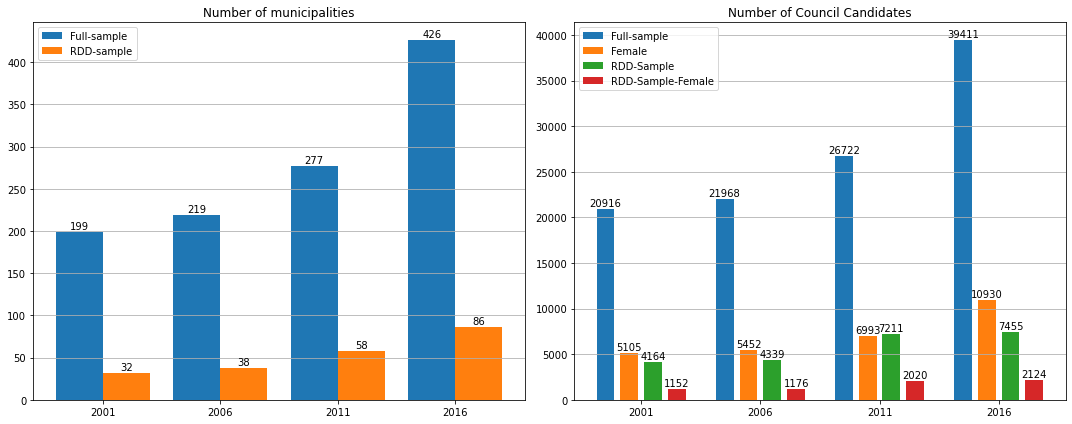

In [6]:
fig1_a=data_fig1_a(data,ext=True)
fig1_b=data_fig1_b(data,ext=True)
plt1_1=(fig1_a[0],"Full-sample")
plt1_2=(fig1_a[1],"RDD-sample")
plt2_1=(fig1_b[0],"Full-sample")
plt2_2=(fig1_b[1],"Female")
plt2_3=(fig1_b[2],"RDD-Sample")
plt2_4=(fig1_b[3],"RDD-Sample-Female")
figure1_plot_extension(plt1_1,plt1_2,plt2_1,plt2_2,plt2_3,plt2_4)

In addition to the total number of municipalities and candidates presented by Baskaran & Hessami (2018), I have added the respective statistics for the rdd-sample that is used in the actual analysis. It is noteworthy, that while the proportion of data used in the regression discontinuity analysis remains constant (ranging from roughly 15 to 20 percent), the total amount of data available in the main analysis is extremly small compared to the overall sample size as presented by the authors. 

In [7]:
rdd=get_rdd_data(data,female=False)
Table1_a_rdd=table1(rdd, dictionary_table1(), female=False)
Table1_b_rdd=table1(rdd, dictionary_table1(), female=True)
display_side_by_side(Table1_a_rdd,Table1_b_rdd)

,count,mean,std,min,max
Rank improvement (normalized),23169.0,0.051748,12.466993,-68.000000,97.297295
Initial list rank (normalized),23169.0,39.327198,26.550978,1.075269,100.000000
Age,11792.0,52.181648,13.866792,18.000000,96.000000
High school,10422.0,0.619363,0.485567,0.000000,1.000000
University,10422.0,0.298023,0.457412,0.000000,1.000000
Phd,10422.0,0.082614,0.275311,0.000000,1.000000
Architect,10534.0,0.010158,0.100276,0.000000,1.000000
Businesswoman/-man,10534.0,0.078223,0.268535,0.000000,1.000000
Engineer,10534.0,0.059711,0.236963,0.000000,1.000000
Lawyer,10534.0,0.037877,0.190909,0.000000,1.000000


When restricting the analysis to the rdd-sample one can observe that now women on average gain ranks, indicating a possible effect of a close gender-mixed mayoral election. This is further supporter by the t-test below. The test shows, that when restricting to the rdd-sample, female and male candidates do not differ significantly in their rank improvement. Unchanged is the result that female candidates remain better placed on the initial list.

In [8]:
tt_rank=t_test_prepare_rank(rdd)
ttest(tt_rank,"Rank")

,Treatment,Control,Diff,Std. Error,Observations
Rank,,,,,
Rank improvement (normalized),0.106,0.031000,0.075,0.183,23169.0
Initial list rank (normalized),37.889,39.884998,-1.996***,0.389,23169.0


##  6.2 Treatment Effect Heterogeneity with Regards to Council Candidate Characteristics<a name= "Treatment_Effect_Heterogeneity_with_Regards_to_Council_Candidate_Characteristics"></a>
---

Additional insight on how the election of a female mayor reduces anti-female voter bias can be gained by searching for heterogeneity in treatment effects. Voters may for example be more inclined to give additional votes to a female candidate if they have a higher degree of education, suggesting a higher qualification for the city council. To test this I perform the analysis as outlined in section 5.3.2 but include dummy variables that equal 1 if a candidate has a university-level education or a PhD degree of education. The results are presented below.

In [13]:
data_rdd_ex=prepare_ext(data_rdd_f)
df_r_ex = DataFrame({"margin_1": FloatVector(data_rdd_ex["margin_1"]), 'gewinn_norm': FloatVector(data_rdd_ex['gewinn_norm'])})
CCT_bw_ext=rdrobust.rdbwselect_2014(df_r_ex.rx2('gewinn_norm'), df_r_ex.rx2('margin_1'), c = 0, p = 1, q = 0, deriv = 0,kernel = "tri", bwselect = "CCT")[2][0]
IK_bw_ext=rdrobust.rdbwselect_2014(df_r_ex.rx2('gewinn_norm'), df_r_ex.rx2('margin_1'), c = 0, p = 1, q = 0, deriv = 0,kernel = "tri", bwselect = "IK")[2][0]
CCT_quad_bw_ext=rdrobust.rdbwselect_2014(df_r_ex.rx2('gewinn_norm'), df_r_ex.rx2('margin_1'), c = 0, p = 2, q = 0, deriv = 0,kernel = "tri", bwselect = "CCT")[2][0]
print("The optimal bandwith according to Calonico, Cattaneo & Titiunik (2014) is: {:5.3f}".format(CCT_bw_ext))
print("The optimal bandwith according to Imbens & Kalyanaraman (2011) is: {:5.3f}".format(IK_bw_ext))
print("The optimal bandwith according to Calonico, Cattaneo & Titiunik (2014) using a quadratic functional form is: {:5.3f}".format(CCT_quad_bw_ext))

The optimal bandwith according to Calonico, Cattaneo & Titiunik (2014) is: 15.871
The optimal bandwith according to Imbens & Kalyanaraman (2011) is: 16.908
The optimal bandwith according to Calonico, Cattaneo & Titiunik (2014) using a quadratic functional form is: 19.737


In [14]:
model_ext_1=[data_rdd_ex,1,CCT_bw_ext,"gewinn_norm","CCT"]
model_ext_2=[data_rdd_ex,1,CCT_bw_ext/2,"gewinn_norm","CCT/2"]
model_ext_3=[data_rdd_ex,1,CCT_bw_ext*2,"gewinn_norm","CCT*2"]
model_ext_4=[data_rdd_ex,1,IK_bw_ext,"gewinn_norm","IK"]
model_ext_5=[data_rdd_ex,2,CCT_quad_bw_ext,"gewinn_norm","CCT"]

In [15]:
reg_tab_ext(model_ext_1,model_ext_2,model_ext_3,model_ext_4,model_ext_5)

,Female Mayor,Std.err_Female Mayor,University,Std.err_University,PhD,Std.err_PhD,Bandwidth type,Bandwidth size,Polynominal,Observations,Elections,Municipalities,Mean,Std.err (Mean)
Model,,,,,,,,,,,,,,
(1),5.48***,1.475,-0.295**,0.748,0.156,1.205,CCT,15.87,Linear,1069.0,54.0,42.0,0.31,10.083
(2),5.764***,1.440,-0.746**,0.929,0.908,2.108,CCT/2,7.94,Linear,699.0,32.0,27.0,0.82,9.947
(3),4.563***,1.156,-0.125**,0.667,-0.056*,0.921,CCT*2,31.74,Linear,1805.0,102.0,69.0,0.16,11.323
(4),5.473***,1.526,-0.268**,0.740,0.105,1.179,IK,16.91,Linear,1091.0,56.0,44.0,0.36,10.142
(5),5.342***,1.536,-0.664**,0.715,0.904,1.091,CCT,19.74,Quadratic,1213.0,63.0,47.0,0.60,10.632


For all models, the table shows a significant negative effect of a university degree on average rank improvement, significant at a level of 5 percent. While the treatment effect of a female mayor is stronger for this subgroup of female candidates in the rdd-sample, the results suggest a backlash-effect against female council candidates with higher education by voters. However, this conclusion is premature, as just like different municipality characteristics (like anti-female voter bias) motivated the initial implementation of a regression discontinuity design, the fact that we observe a negative effect of higher qualification may originate from different preferences in the educational level of politicians. <br> In the online appendix Baskaran & Hessami (2018) relate individual candidate characteristics to their election performance by including corresponding characteristics as well. However, they also include those characteristics for the mayor of the municipality. When controlling for differences in educational levels between mayor and council candidates, a higher degree of education exerts a positive influence on female candidate performance. While their findings differ in statistical significance for model specifications these results in combination with my results above, suggest that municipalities may have a distinct preference with regards to the academic qualification of their politicians. However, a more detailed analysis may result in robust results and conclusive insight on that topic. 

---
#  7. Critical Assessment and Conclusion <a name="Critical_Assessment_and_Conclusion"></a>
---

To summarize, my findings generally support the results of Baskaran & Hessami (2018). Except for small deviations in standard errors for regression results, I was able to understand and replicate all key numerical results by the authors in an exact manner. Since the differences in standard errors are generally small and do not change the significance of results, and the fact that authors and I use the heteroscedastic clustered standard errors I attribute the difference to the fact that Baskaran & Hessami (2018) relied on Stata for their derivations. Economically, the authors applied the methodology of a regression discontinuity design in an intriguing setting. It is generally a considerable challenge to identify causal effects in election results. Through the application of a regression discontinuity design, such issues become solvable. To validate this approach the authors checked the necessary condition of a continuous running variable. Additionally, they tested the relevance of observable covariates in the treatment assignment. While this showed no significant differences, the selection of covariates deserves a closer look. While the characteristics of a municipality used by the authors serve as a good proxy to categorize municipalities, the inclusion of additional covariates, that capture the political climate within a municipality more accurately can yield additional robustness. While generally, all parties encourage the increased political participation of women, they differ to the extent to which they actively support it. To test this possible confound of political ideology, the authors analyze differences in party membership of mayor candidates.  Although this serves as a proxy for the general political climate in a municipality,  it only projects the *median* political climate. A possible additional covariate in this context can be an index of the previous party composition of a local council. If there are no significant differences observable this would further strengthen the result of Baskaran & Hessami (2008).<br>
Concerning the bandwidth choice,  the authors provided strong evidence of a significant effect since they tested their model for a wide range of bandwidth choices. For normalized rank improvement as a dependent variable, all models show a significant treatment effect. Concerning the model where the gender of an elected council member is the outcome variable, it might be initially a disappointment to observe no statistically significant effect. However, as Baskaran & Hesssami (2008) point out, this is due to the effect that their average rank improvement will only result in elections for those candidates, with a good enough initial rank. Consequently, we only observe an effect of treatment on the margin. This however does not change the significance of the treatment as a whole due to the more accurate variable rank improvement. In this regard, it may prove worthwhile to revisit this experimental setting, when more data is available. 
Overall, the results of Baskaran & Hessami are very robust.
Finally, it has to be highlighted that the authors worked very transparently. The required datasets and detailed descriptions of the collection procedure are available in the online appendix. The original Stata code used by the authors to produce all results in the original paper and the online appendix is also provided. That generally allowed me to understand choices of parameters, so that I could assess and apply them in a python environment accordingly.Through this and the expansion of python to R via rp2y I was able to find strong support for the findings of Baskaran & Hessami (2018).

---
#  8. References <a name="Keks"></a>
---

* **Baskaran, T., & Hessami, Z. (2018).** Does the Election of a Female Leader Clear the Way for More Women in Politics? American economic journal. Economic policy, 10(3), 95-121. doi:10.1257/pol.20170045.
<br>
* **Calonico, S., Cattaneo, M. D., & Titiunik, R. (2014).** Robust Nonparametric Confidence Intervals for Regression-Discontinuity Designs: Robust Nonparametric Confidence Intervals. Econometrica, 82(6), 2295-2326. doi:10.3982/ECTA11757. 
<br>
* **Eisenhauer, P. (2020).** Course project template, HumanCapitalAnalysis.
<br>
* **Gehlen, A. (2019).** Replication of Jason M. Lindo, Nicholas J. Sanders & Philip Oreopoulos (2010).
<br>
* **Imbens, G., & Kalyanaraman, K. (2011).** Optimal Bandwidth Choice for the Regression Discontinuity Estimator. The Review of economic studies, 79(3), 933-959. doi:10.1093/restud/rdr043. 
<br>
* **Lee, D. S., & Lemieux, T. (2010).** Regression Discontinuity Designs in Economics. Journal of Economic Literature, 48(2), 281-355. doi:10.1257/jel.48.2.281. 


